<a href="https://colab.research.google.com/github/berilcankutlu/Amazon_review_sentiment_analysis/blob/main/amazon_review_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Yorumlarının Duygu Analizinin Yapılması

Gerekli Kütüphanelerin Eklenmesi

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from textblob import Word, TextBlob
from sklearn.model_selection import cross_val_score, train_test_split,  GridSearchCV, cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from nltk.sentiment import SentimentIntensityAnalyzer
from warnings import filterwarnings
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder


filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)
pd.set_option("display.float_format", lambda x: "%2f" %x)

df = pd.read_excel("amazon.xlsx")
df.head()

,Star,HelpFul,Title,Review
0,5,0,looks great,Happy with it
1,5,0,Pattern did not align between the two panels.,Good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,Product was fun for bedroom windows.<br />Imag...
3,5,0,Que se ven elegantes muy finas,Lo unico que me gustaria es que sean un poco ...
4,5,0,Wow great purchase,Great bang for the buck I can't believe the qu...


Metin Ön işleme

In [ ]:
# Metindeki harflerin küçültülmesi
df["Review"] = df["Review"].str.lower()

# Sayısal ifadeler ile noktalama işaretlerinin çıkarılması
df["Review"] = df["Review"].str.replace("[^\w\s]", '')
df["Review"] = df["Review"].str.replace("\d", '')

# Bilgi içermeyen kelimelerin çıkarılması
import nltk
nltk.download('stopwords')
sw = stopwords.words("english")
df['Review'] = df['Review'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

# 1000'den az geçen kelimelerin çıkarılması
drops = pd.Series(" ".join(df["Review"]).split()).value_counts()[-1000:]
df["Review"] = df["Review"].apply(lambda x: " ".join(x for x in x.split() if x not in drops))


#Tokenization: Kelimeleri ayırma
nltk.download("punkt_tab")
df["Review"].apply(lambda x: TextBlob(x).words).head()

# Lemmatization : Kelimeleri köklerine ayırma
nltk.download("wordnet")
df["Review"] = df["Review"].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

print(df["Review"].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0                                                happy
1     good quality material however panel mis-matched.
2    product fun bedroom windows.<br bit stretched,...
3                                 lo que e que un poco
4    great bang buck can't believe quality material...
Name: Review, dtype: object


Metin Görselleştirme

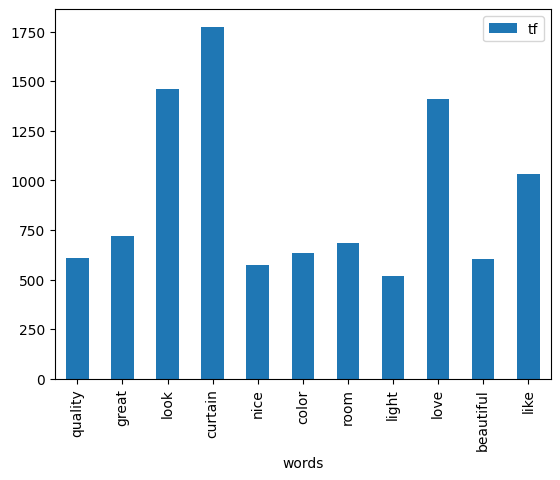

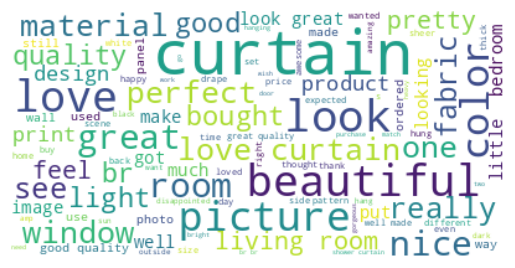

In [ ]:
# Terim frekanslarının hesaplanması
tf = df["Review"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
tf.columns = ["words", "tf"]
tf.sort_values("tf", ascending=False)

# Barplot
tf[tf["tf"] > 500].plot.bar(x="words", y="tf")
plt.show()

# WordCloud
text = " ".join(i for i in df.Review)
wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

wordcloud.to_file("wordcloud.png")


Duygu Analizi

In [ ]:
nltk.download("vader_lexicon")
sia = SentimentIntensityAnalyzer()
df["Review"][0:10].apply(lambda x: sia.polarity_scores(x))
df["Review"][0:10].apply(lambda x: sia.polarity_scores(x)["compound"])
df["Review"][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")
df["Sentiment_Label"] = df["Review"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")
print(df["Sentiment_Label"].head())

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


0    pos
1    pos
2    pos
3    neg
4    pos
Name: Sentiment_Label, dtype: object


ML Hazırlık

In [ ]:
tf_idf_vectorizer = TfidfVectorizer().fit(train_x)
x_train_tf_idf_word = tf_idf_vectorizer.transform(train_x)
x_test_tf_idf_word = tf_idf_vectorizer.transform(test_x)


Logistic Regression

In [ ]:
log_model = LogisticRegression().fit(x_train_tf_idf_word, train_y)
y_pred = log_model.predict(x_test_tf_idf_word)
cross_val_score(log_model,
                x_train_tf_idf_word,
                train_y,
                scoring="accuracy",
                cv=5).mean()
# %89


np.float64(0.887119451168019)

Random Forest

In [ ]:
rf_model = RandomForestClassifier().fit(x_train_tf_idf_word, train_y)
cross_val_score(rf_model,
                x_train_tf_idf_word,
                train_y,
                scoring="accuracy",
                cv=5).mean()
# %91

np.float64(0.9170614668093915)